<a href="https://colab.research.google.com/github/TOga1220/pytorch_tutorial/blob/main/20210430_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 時系列データの異常検知
オートエンコーダ（自動符号化器）による時系列データ（気温データ）の解析、異常値検出を行うセクション


In [2]:
# パッケージのインポート
import torch
from torch.autograd import Variable
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset 

In [3]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt 
%matplotlib inline

In [4]:
data  = pd.read_csv('/content/drive/MyDrive/Udemy/Pytorch/data.csv', skiprows=[0,1,2,4], encoding='shift-jis' )

In [5]:
data

,年月日,平均気温(℃),平均気温(℃).1,平均気温(℃).2
0,2012/1/1,5.7,8,1
1,2012/1/2,6.0,8,1
2,2012/1/3,6.6,8,1
3,2012/1/4,5.4,8,1
4,2012/1/5,5.5,8,1
...,...,...,...,...
2187,2017/12/27,4.5,8,2
2188,2017/12/28,4.8,8,2
2189,2017/12/29,6.1,8,2
2190,2017/12/30,6.2,8,2


In [6]:
temp_data = data['平均気温(℃)']
temp_data

0       5.7
1       6.0
2       6.6
3       5.4
4       5.5
       ... 
2187    4.5
2188    4.8
2189    6.1
2190    6.2
2191    3.8
Name: 平均気温(℃), Length: 2192, dtype: float64

In [7]:
data[1820:1830]

,年月日,平均気温(℃),平均気温(℃).1,平均気温(℃).2
1820,2016/12/25,6.6,8,2
1821,2016/12/26,6.9,8,2
1822,2016/12/27,11.1,8,2
1823,2016/12/28,6.0,8,2
1824,2016/12/29,4.3,8,2
1825,2016/12/30,6.0,8,2
1826,2016/12/31,6.3,8,2
1827,2017/1/1,7.4,8,2
1828,2017/1/2,7.2,8,2
1829,2017/1/3,8.0,8,2


In [8]:
train_x = temp_data[:1827]
test_x = temp_data[1827:]
train_x = np.array(train_x)
test_x  = np.array(test_x)


In [9]:
print(len(train_x))
print(len(test_x))

1827
365


In [10]:
# ミニバッチ用のデータを作る。

window_size = 180   # 180日間のデータを切り取る
tmp = []
train_X = []

for i in range(0, len(train_x)-window_size):
  tmp.append(train_x[i : i+window_size])

train_X = np.array(tmp)

In [11]:
pd.DataFrame(train_X)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
0,5.7,6.0,6.6,5.4,5.5,6.3,5.7,5.8,5.9,6.7,5.8,3.8,5.6,5.1,4.5,4.5,4.9,5.4,6.2,2.8,3.4,5.3,5.0,3.0,4.1,3.2,3.2,2.6,2.9,3.7,4.1,6.0,2.6,2.8,5.5,6.1,4.9,7.7,6.6,4.7,...,21.3,20.2,14.6,18.7,22.0,20.4,21.0,22.5,21.4,20.7,20.1,20.3,21.3,21.6,20.3,22.1,21.7,19.4,21.1,23.5,19.0,21.9,20.0,16.9,17.4,18.6,20.3,20.2,23.3,24.5,23.9,26.9,23.7,21.1,22.2,22.6,18.4,19.5,20.6,22.5
1,6.0,6.6,5.4,5.5,6.3,5.7,5.8,5.9,6.7,5.8,3.8,5.6,5.1,4.5,4.5,4.9,5.4,6.2,2.8,3.4,5.3,5.0,3.0,4.1,3.2,3.2,2.6,2.9,3.7,4.1,6.0,2.6,2.8,5.5,6.1,4.9,7.7,6.6,4.7,5.7,...,20.2,14.6,18.7,22.0,20.4,21.0,22.5,21.4,20.7,20.1,20.3,21.3,21.6,20.3,22.1,21.7,19.4,21.1,23.5,19.0,21.9,20.0,16.9,17.4,18.6,20.3,20.2,23.3,24.5,23.9,26.9,23.7,21.1,22.2,22.6,18.4,19.5,20.6,22.5,23.4
2,6.6,5.4,5.5,6.3,5.7,5.8,5.9,6.7,5.8,3.8,5.6,5.1,4.5,4.5,4.9,5.4,6.2,2.8,3.4,5.3,5.0,3.0,4.1,3.2,3.2,2.6,2.9,3.7,4.1,6.0,2.6,2.8,5.5,6.1,4.9,7.7,6.6,4.7,5.7,5.4,...,14.6,18.7,22.0,20.4,21.0,22.5,21.4,20.7,20.1,20.3,21.3,21.6,20.3,22.1,21.7,19.4,21.1,23.5,19.0,21.9,20.0,16.9,17.4,18.6,20.3,20.2,23.3,24.5,23.9,26.9,23.7,21.1,22.2,22.6,18.4,19.5,20.6,22.5,23.4,23.3
3,5.4,5.5,6.3,5.7,5.8,5.9,6.7,5.8,3.8,5.6,5.1,4.5,4.5,4.9,5.4,6.2,2.8,3.4,5.3,5.0,3.0,4.1,3.2,3.2,2.6,2.9,3.7,4.1,6.0,2.6,2.8,5.5,6.1,4.9,7.7,6.6,4.7,5.7,5.4,5.0,...,18.7,22.0,20.4,21.0,22.5,21.4,20.7,20.1,20.3,21.3,21.6,20.3,22.1,21.7,19.4,21.1,23.5,19.0,21.9,20.0,16.9,17.4,18.6,20.3,20.2,23.3,24.5,23.9,26.9,23.7,21.1,22.2,22.6,18.4,19.5,20.6,22.5,23.4,23.3,21.9
4,5.5,6.3,5.7,5.8,5.9,6.7,5.8,3.8,5.6,5.1,4.5,4.5,4.9,5.4,6.2,2.8,3.4,5.3,5.0,3.0,4.1,3.2,3.2,2.6,2.9,3.7,4.1,6.0,2.6,2.8,5.5,6.1,4.9,7.7,6.6,4.7,5.7,5.4,5.0,5.8,...,22.0,20.4,21.0,22.5,21.4,20.7,20.1,20.3,21.3,21.6,20.3,22.1,21.7,19.4,21.1,23.5,19.0,21.9,20.0,16.9,17.4,18.6,20.3,20.2,23.3,24.5,23.9,26.9,23.7,21.1,22.2,22.6,18.4,19.5,20.6,22.5,23.4,23.3,21.9,22.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1642,23.0,25.6,27.0,29.2,27.8,21.7,23.1,27.4,25.3,22.4,25.6,28.0,27.1,25.1,25.9,22.2,24.1,25.9,28.7,27.3,26.3,21.8,21.4,22.4,23.9,24.7,23.8,24.5,26.5,27.2,27.2,27.5,27.4,25.9,26.8,28.1,28.7,29.1,28.6,28.5,...,12.6,11.3,9.8,13.6,12.6,14.0,11.4,2.8,5.6,8.3,10.6,11.1,10.5,8.8,10.0,11.5,10.8,11.6,12.7,10.8,7.5,8.6,11.1,8.5,6.8,7.0,9.4,8.1,6.2,4.8,6.7,8.2,10.0,9.6,10.5,14.6,14.0,8.6,6.6,6.9
1643,25.6,27.0,29.2,27.8,21.7,23.1,27.4,25.3,22.4,25.6,28.0,27.1,25.1,25.9,22.2,24.1,25.9,28.7,27.3,26.3,21.8,21.4,22.4,23.9,24.7,23.8,24.5,26.5,27.2,27.2,27.5,27.4,25.9,26.8,28.1,28.7,29.1,28.6,28.5,31.9,...,11.3,9.8,13.6,12.6,14.0,11.4,2.8,5.6,8.3,10.6,11.1,10.5,8.8,10.0,11.5,10.8,11.6,12.7,10.8,7.5,8.6,11.1,8.5,6.8,7.0,9.4,8.1,6.2,4.8,6.7,8.2,10.0,9.6,10.5,14.6,14.0,8.6,6.6,6.9,11.1
1644,27.0,29.2,27.8,21.7,23.1,27.4,25.3,22.4,25.6,28.0,27.1,25.1,25.9,22.2,24.1,25.9,28.7,27.3,26.3,21.8,21.4,22.4,23.9,24.7,23.8,24.5,26.5,27.2,27.2,27.5,27.4,25.9,26.8,28.1,28.7,29.1,28.6,28.5,31.9,29.1,...,9.8,13.6,12.6,14.0,11.4,2.8,5.6,8.3,10.6,11.1,10.5,8.8,10.0,11.5,10.8,11.6,12.7,10.8,7.5,8.6,11.1,8.5,6.8,7.0,9.4,8.1,6.2,4.8,6.7,8.2,10.0,9.6,10.5,14.6,14.0,8.6,6.6,6.9,11.1,6.0
1645,29.2,27.8,21.7,23.1,27.4,25.3,22.4,25.6,28.0,27.1,25.1,25.9,22.2,24.1,25.9,28.7,27.3,26.3,21.8,21.4,22.4,23.9,24.7,23.8,24.5,26.5,27.2,27.2,27.5,27.4,25.9,26.8,28.1,28.7,29.1,28.6,28.5,31.9,29.1,27.3,...,13.6,12.6,14.0,11.4,2.8,5.6,8.3,10.6,11.1,10.5,8.8,10.0,11.5,10.8,11.6,12.7,10.8,7.5,8.6,11.1,8.5,6.8,7.0,9.4,8.1,6.2,4.8,6.7,8.2,10.0,9.6,10.5,14.6,14.0,8.6,6.6,6.9,11.1,6.0,4.3


In [12]:
# モデルの定義

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(180, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 128)
    self.fc4 = nn.Linear(128, 180)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

model = Net()

In [13]:
criterion = nn.MSELoss()   # 平均二乗和誤差
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 勾配降下法の一つ（SDGやAdaGradなどの改良版）  lr:学習率

for epoch in range(500):   # １０００回学習
  total_loss = 0
  input_x = []

  for i in range(100):   #180日のデータから100個取り出す
    index = np.random.randint(0,1647)
    input_x.append(train_X[index])
  input_x = np.array(input_x, dtype='float32')
  input_x = Variable(torch.from_numpy(input_x))

  optimizer.zero_grad()
  output = model(input_x)

  loss = criterion(output, input_x)
  loss.backward()   # 誤差成分を上流へ伝播⇨微分値で各パラメータを更新できる
  optimizer.step()

  total_loss += loss.item()

  if (epoch+1) % 100 == 0:
    print(epoch+1, total_loss) 

100 9.119512557983398
200 5.5248894691467285
300 5.571990489959717
400 5.403415203094482
500 5.413751602172852


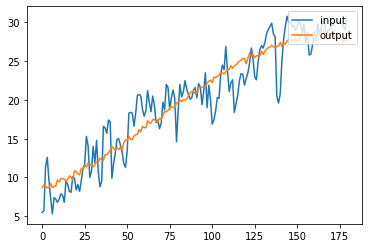

In [14]:
# 入力値と出力値のplot
plt.plot(input_x.data[0].numpy(), label='input')
plt.plot(output.data[0].numpy(), label='output')
plt.legend(loc='upper right')

In [15]:
# テストデータの出力計算
input_x = []
test_X = []


input_x.append(test_x[0:180])
input_x.append(test_x[180:360])

test_X  = np.array(input_x, dtype='float32')

pd.DataFrame(test_X)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
0,7.400000,7.2,8.000000,8.500000,6.700000,4.500000,4.100000,3.9,7.2,8.100000,6.9,6.000000,6.2,2.4,0.700000,3.2,5.4,5.800000,6.400000,3.0,5.900000,6.0,4.000000,2.500000,3.9,4.6,8.8,8.400000,8.000000,11.200000,5.9,6.0,4.500000,7.4,8.200000,7.2,8.700000,5.6,6.300000,2.400000,...,23.799999,23.200001,22.5,22.200001,20.9,18.799999,20.9,20.9,21.5,23.299999,23.6,21.5,23.0,21.4,21.0,19.6,19.6,20.299999,22.0,23.1,24.6,21.700001,20.5,16.9,19.299999,21.299999,22.4,22.299999,19.5,22.6,22.700001,22.4,24.0,24.6,24.6,22.299999,23.1,23.200001,22.4,24.6
1,23.799999,23.4,25.700001,28.299999,26.799999,26.299999,26.200001,27.0,27.9,27.299999,27.4,27.700001,28.9,28.5,28.200001,28.1,28.9,29.700001,26.299999,26.5,28.200001,29.1,28.700001,27.299999,29.1,29.4,24.6,24.200001,26.799999,26.799999,25.6,28.0,26.299999,22.9,24.299999,25.6,27.799999,29.0,28.700001,29.299999,...,9.900000,10.700000,8.6,6.400000,7.9,7.100000,9.4,9.4,9.1,11.600000,11.4,11.6,12.7,11.0,8.5,7.6,8.2,8.800000,9.2,6.9,6.4,5.700000,5.9,6.9,9.900000,6.800000,5.9,5.700000,5.4,7.7,6.100000,4.4,6.5,5.7,5.3,5.400000,7.1,7.400000,9.4,7.5


In [29]:
print(test_x.shape) 

(365,)


In [16]:
input_test = Variable(torch.from_numpy(test_X))
output = model(input_test)

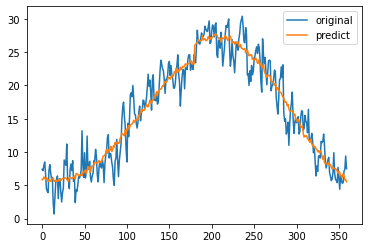

In [17]:
plt.plot(test_X.flatten(), label = 'original')
plt.plot(output.data.numpy().flatten(), label='predict')
plt.legend(loc='upper right')

In [19]:
test = test_X.flatten()
predict = output.data.numpy().flatten()

total_score = []
for i in range(0, 360):
  diff = test[i] - predict[i]
  score = pow(diff, 2)  # pow:累乗
  total_score.append(score)

total_score = np.array(total_score)  #numpy配列にすることで配列要素をまとめて計算しやすくする
max_score = np.max(total_score)
total_score = total_score / max_score  #max_scoreで正規化（0〜１の値に変換する）


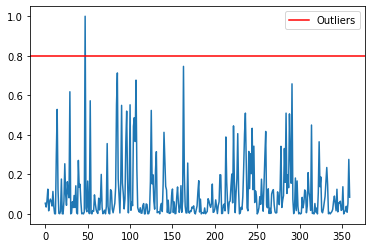

In [26]:
plt.plot(total_score)
plt.axhline(y=0.8, xmin=0, xmax=360, color="red", label='Outliers')
plt.legend(loc='upper right')

In [ ]:
# 異常スコアに閾値を設けると、閾値を超える箇所は異常とみなすことができる。
# 正常なら「０」、異常なら「１」のフラグを立てて教師データを作成すれば、閾値を超える箇所が「１」となる。